/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_13612/2383612388.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed
/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_13612/2383612388.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()
[*********************100%***********************]  10 of 10 completed


Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Processing pair: IEMG & EEM
Processing pair: ARKK & ARKW
Processing pair: TLT & SPTL
Processing pair: SHY & VGSH
Processing pair: SOXX & ITA
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END class_weight=bala

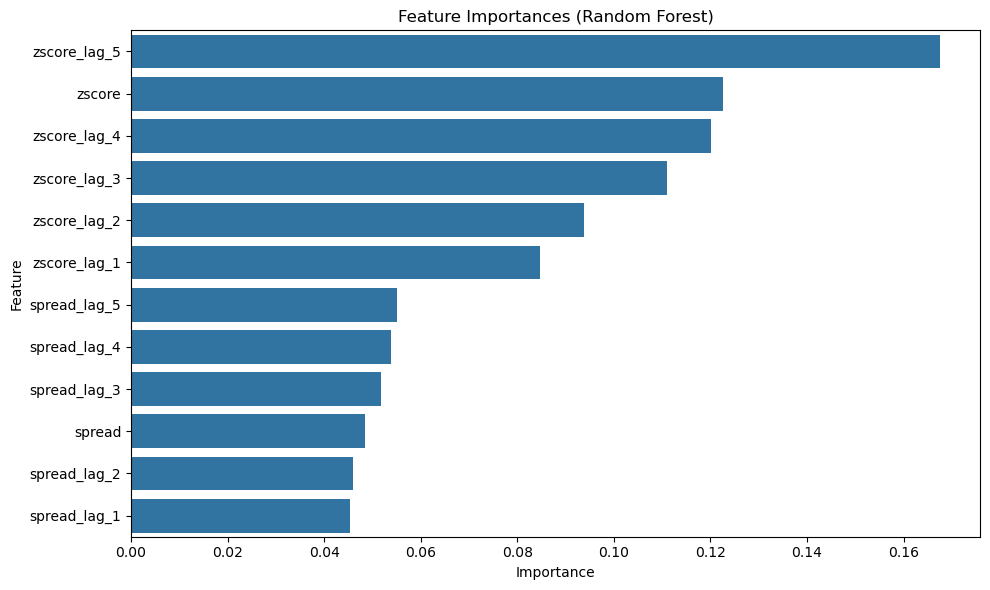

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Define ETF pairs and date ranges
# -----------------------------
etf_pairs = [['IEMG', 'EEM'], ['ARKK', 'ARKW'], ['TLT', 'SPTL'], ['SHY', 'VGSH'], ['SOXX', 'ITA']]
downloadable_tickers = list(set([etf for pair in etf_pairs for etf in pair]))

train_start = "2015-01-01"
train_end = "2020-01-01"
test_start = "2020-01-02"
test_end = "2024-12-31"

# -----------------------------
# 2. Download training and testing data
# -----------------------------
train_prices = yf.download(downloadable_tickers, start=train_start, end=train_end)["Close"].dropna()
test_prices = yf.download(downloadable_tickers, start=test_start, end=test_end)["Close"].dropna()

# -----------------------------
# 3. Function to process a pair
# -----------------------------
def process_pair(etf1, etf2, price_data, lookback=60):
    df = pd.DataFrame(index=price_data.index)
    df["etf1"] = price_data[etf1]
    df["etf2"] = price_data[etf2]

    # Hedge ratio
    df["hedge_ratio"] = (
        df["etf1"].rolling(lookback).cov(df["etf2"]) /
        df["etf2"].rolling(lookback).var()
    )

    # Spread and z-score
    df["spread"] = df["etf1"] - df["hedge_ratio"] * df["etf2"]
    spread_mean = df["spread"].rolling(lookback).mean()
    spread_std = df["spread"].rolling(lookback).std()
    df["zscore"] = (df["spread"] - spread_mean) / spread_std

    # Lag features
    for i in range(1, 6):
        df[f"spread_lag_{i}"] = df["spread"].shift(i)
        df[f"zscore_lag_{i}"] = df["zscore"].shift(i)

    # Target = mean reversion
    df["target"] = (
        (df["zscore"].shift(-1).abs() < df["zscore"].abs()).astype(int)
    )
    df["pair"] = f"{etf1}_{etf2}"

    return df.dropna()

# -----------------------------
# 4. Process all pairs
# -----------------------------
def process_all_pairs(pairs, price_data):
    processed = []
    for etf1, etf2 in pairs:
        print(f"Processing pair: {etf1} & {etf2}")
        processed.append(process_pair(etf1, etf2, price_data))
    return pd.concat(processed)

train_df = process_all_pairs(etf_pairs, train_prices)
test_df = process_all_pairs(etf_pairs, test_prices)

# -----------------------------
# 5. Feature columns
# -----------------------------
feature_cols = [
    'spread', 'zscore',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

X_train, y_train = train_df[feature_cols], train_df["target"]
X_test, y_test = test_df[feature_cols], test_df["target"]

# -----------------------------
# 6. Train Random Forest with Grid Search
# -----------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# -----------------------------
# 7. Evaluate ONLY on Test Set
# -----------------------------
y_pred = best_rf.predict(X_test)

print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("True Label Distribution:", Counter(y_test))
print("Predicted Label Distribution:", Counter(y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 8. Feature Importance
# -----------------------------
importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


In [24]:
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

print("\n📊 Classification Report (Test Data Only):\n", classification_report(y_test, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("🔹 True Label Distribution (Test):", Counter(y_test))
print("🔹 Predicted Label Distribution (Test):", Counter(y_pred))



📊 Classification Report (Test Data Only):
               precision    recall  f1-score   support

           0       0.68      0.62      0.65      2428
           1       0.73      0.78      0.75      3242

    accuracy                           0.71      5670
   macro avg       0.70      0.70      0.70      5670
weighted avg       0.71      0.71      0.71      5670

✅ Accuracy: 0.7097
🔹 True Label Distribution (Test): Counter({1: 3242, 0: 2428})
🔹 Predicted Label Distribution (Test): Counter({np.int64(1): 3448, np.int64(0): 2222})


## 📈 Mean Reversion Classification Report (Test Data: 2020–2024)

- **Accuracy**: 71%  
  The model correctly predicts mean reversion signals about **7 out of 10 times**.

### 🔍 Class Performance
- **Class 0 (No Mean Reversion)**  
  - **Precision**: 68% — When predicting no signal, 68% were correct.  
  - **Recall**: 61% — Correctly caught 61% of actual "no signal" cases.  
  - **F1-Score**: 64% — Balance of precision and recall.

- **Class 1 (Mean Reversion Signal)**  
  - **Precision**: 73% — When predicting a signal, 73% were correct.  
  - **Recall**: 78% — Correctly detected 78% of actual signals.  
  - **F1-Score**: 75% — Stronger at detecting signals.

### ⚖️ Class Distribution
- **True Labels**:  
  - Class 1 (Signal): 3,241  
  - Class 0 (No Signal): 2,429  

- **Predicted Labels**:  
  - Class 1 (Signal): 3,474  
  - Class 0 (No Signal): 2,196  

💡 **Interpretation:**  
The model is **stronger at identifying mean reversion opportunities (Class 1)** than correctly ruling out false signals (Class 0). This bias may be beneficial if your priority is **not missing potential trades**, even at the expense of more false positives.


/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_13612/3089195314.py:183: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_equity = pd.concat(all_equities, axis=1).fillna(method="ffill")



📊 Pair Summary (Test Data Only)
     Pair  Final Value ($)  Total Return (%)  CAGR (%)  Sharpe  Max Drawdown (%)  Trades
ARKK_ARKW            95.87             -3.31     -0.74   -0.22              7.39      51
 IEMG_EEM            99.07             -0.98     -0.22   -0.62              0.98      69
 SHY_VGSH           100.02              0.01      0.00    0.08              0.06      55
 SOXX_ITA            99.81             -0.19     -0.04    0.02             11.00      61
 TLT_SPTL           100.01              0.01      0.00    0.01              0.43      55

📈 Total Portfolio (All Pairs, Test Data)
  Initial Value: $499.22
  Final Value:   $494.79
  Total Return:   -0.89%
  CAGR:           -0.20%
  Sharpe:         -0.13
  Max Drawdown:   2.90%


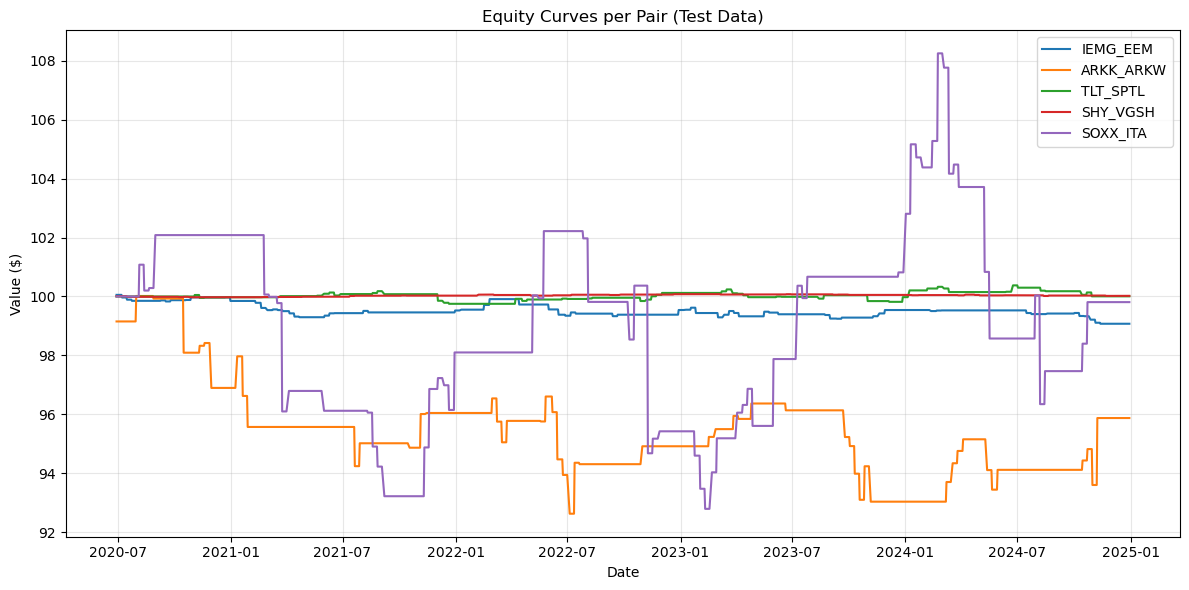

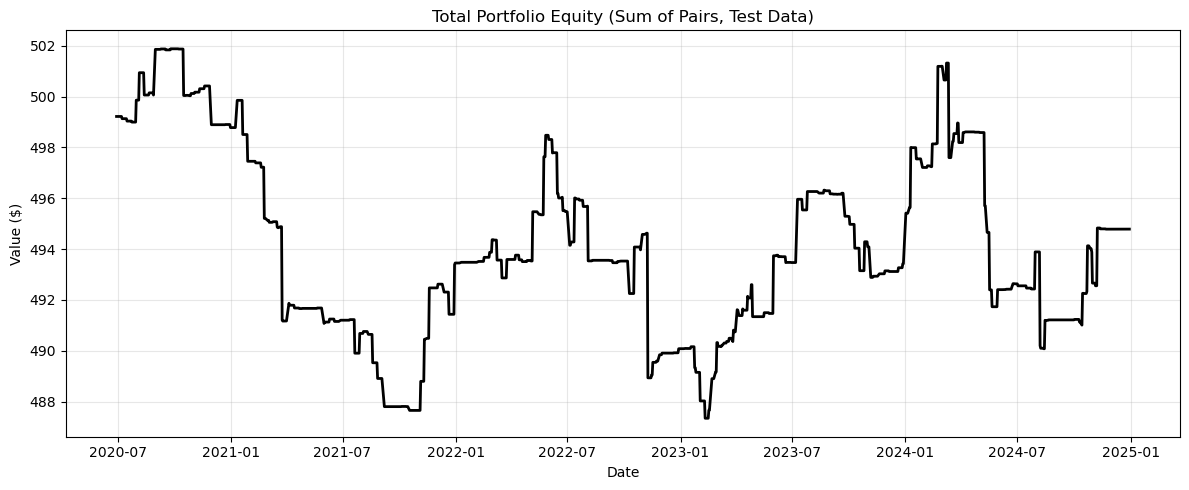

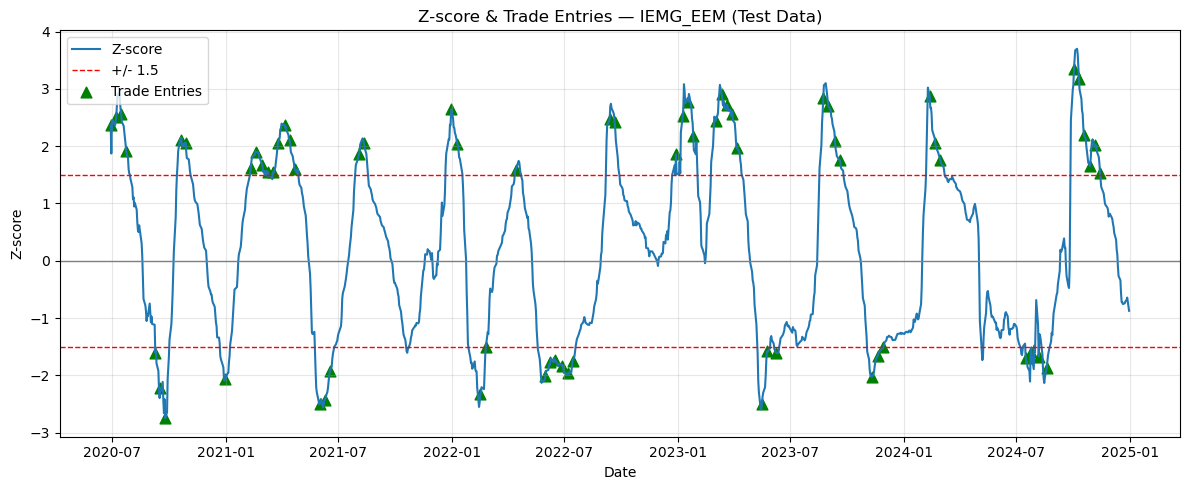

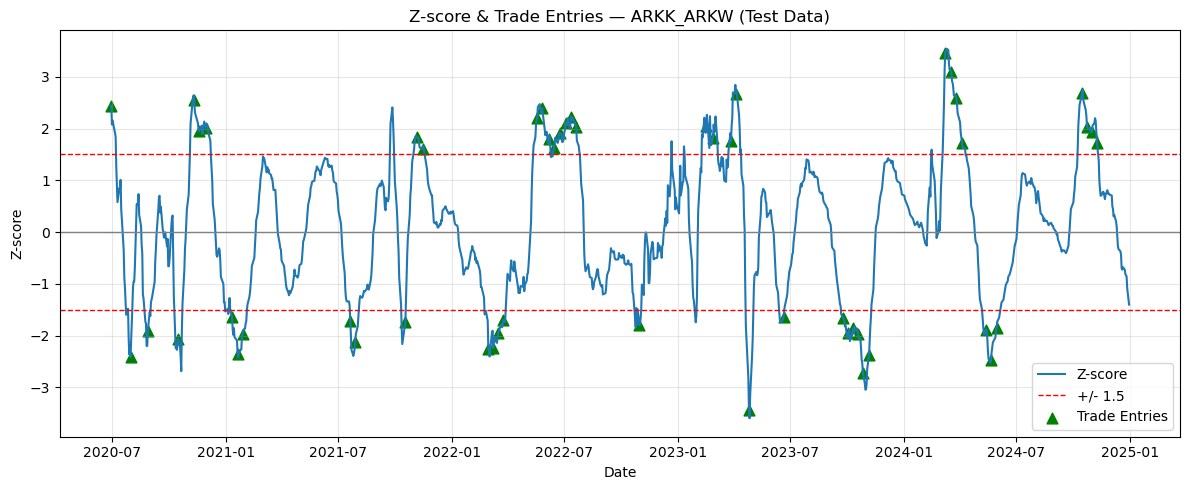

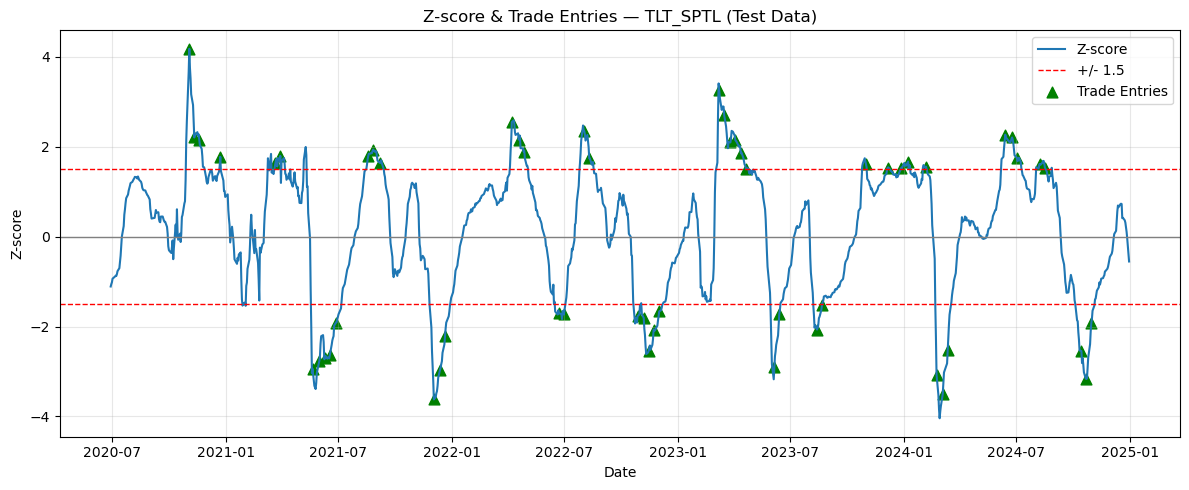

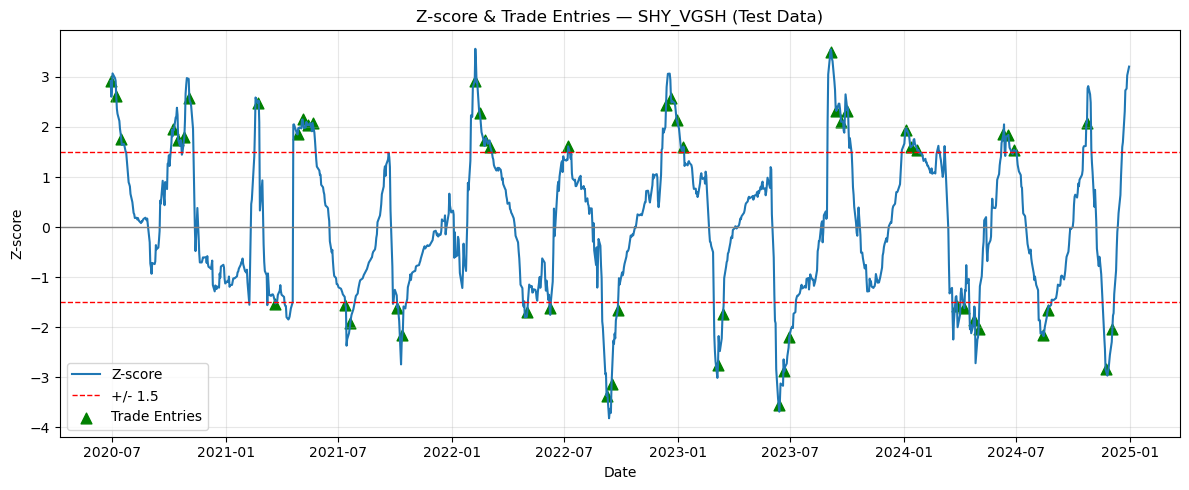

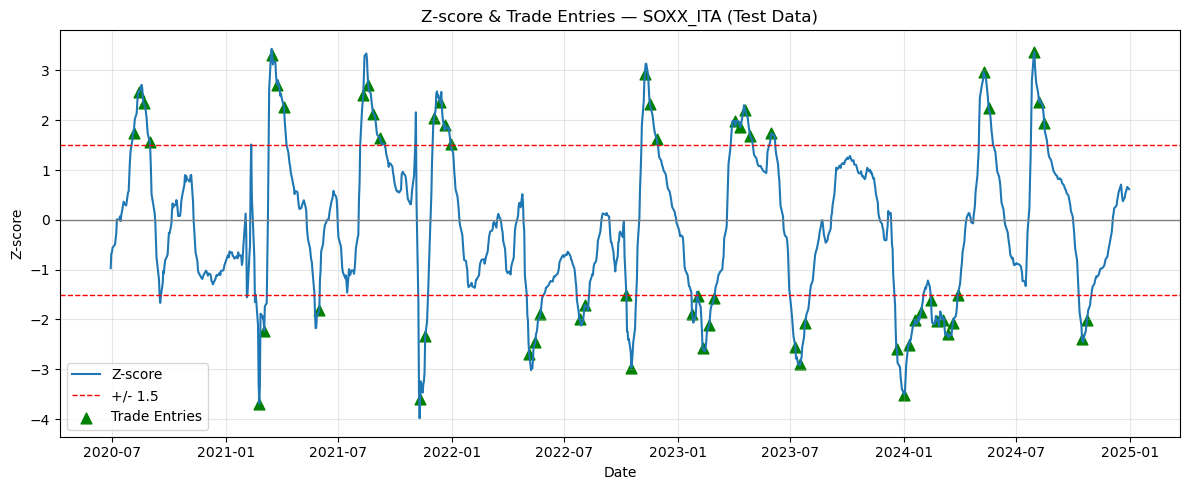

In [28]:
# =========================================================
# 9) NEW: Mock portfolio on TEST DATA (2020–2024)
#     $100 starting per pair, no overlapping trades per pair
#     Uses model predictions (mean reversion = 1)
# =========================================================
from dataclasses import dataclass
import numpy as np

# Make predictions on test set and attach to test_df
test_df = test_df.copy()
test_df["pred"] = best_rf.predict(test_df[feature_cols])

# ----- Helper metrics -----
def max_drawdown(series: pd.Series) -> float:
    cummax = series.cummax()
    dd = (cummax - series) / cummax
    return float(dd.max()) if len(dd) else 0.0

def annualized_sharpe(equity: pd.Series, periods_per_year=252) -> float:
    rets = equity.pct_change().dropna()
    if rets.std() == 0 or len(rets) == 0:
        return 0.0
    return float((rets.mean() / rets.std()) * np.sqrt(periods_per_year))

def annualized_cagr(equity: pd.Series) -> float:
    if equity.empty:
        return 0.0
    start_val = equity.iloc[0]
    end_val = equity.iloc[-1]
    if start_val <= 0:
        return 0.0
    # Use calendar days to be robust to gaps
    n_days = (equity.index[-1] - equity.index[0]).days
    years = max(n_days / 365.25, 1e-9)
    return float((end_val / start_val) ** (1 / years) - 1)

@dataclass
class PairResult:
    pair: str
    equity: pd.Series          # daily equity series for the pair
    trades: pd.DataFrame       # trade log with entry/exit/pnl
    final_value: float
    total_return_pct: float
    cagr_pct: float
    sharpe: float
    mdd_pct: float
    n_trades: int

# ----- Core simulator for ONE pair -----
def simulate_pair(
    pair_df: pd.DataFrame,
    initial_cash_per_pair: float = 100.0,
    holding_period: int = 5,
    entry_threshold: float = 1.5,
    use_compounding: bool = True,
) -> PairResult:
    """
    Trading rule:
    - Enter only when model predicts mean reversion (pred==1) AND |zscore| >= entry_threshold.
    - Direction: if z>0, short ETF1 & long ETF2; if z<0, long ETF1 & short ETF2.
    - Hold exactly `holding_period` days, then exit.
    - Position sizing: use current cash for notional (compounding) or initial (fixed).
    - No overlapping trades per pair.
    """
    df = pair_df.sort_index().copy()
    pair_name = df["pair"].iloc[0]
    cash = float(initial_cash_per_pair)

    # Equity series: start at initial cash, jump on exit days
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = cash

    trades = []
    i = 0
    n = len(df)

    while i < n - holding_period:
        row = df.iloc[i]
        # Entry condition
        if (row["pred"] == 1) and (abs(row["zscore"]) >= entry_threshold):
            # Entry info
            entry_idx = i
            exit_idx = i + holding_period

            entry_date = df.index[entry_idx]
            exit_date  = df.index[exit_idx]

            price1_in  = df.iloc[entry_idx]["etf1"]
            price2_in  = df.iloc[entry_idx]["etf2"]
            price1_out = df.iloc[exit_idx]["etf1"]
            price2_out = df.iloc[exit_idx]["etf2"]

            z = row["zscore"]
            # Notional
            notional = cash if use_compounding else initial_cash_per_pair
            long_dollars  = notional / 2.0
            short_dollars = notional / 2.0

            # Direction based on z-score
            if z > 0:
                # ETF1 expensive -> short ETF1, long ETF2
                shares_short1 = short_dollars / price1_in
                shares_long2  = long_dollars  / price2_in
                pnl = (shares_long2 * (price2_out - price2_in)) + (shares_short1 * (price1_in - price1_out))
                direction = "Short ETF1 / Long ETF2"
            else:
                # ETF2 expensive -> long ETF1, short ETF2
                shares_long1  = long_dollars  / price1_in
                shares_short2 = short_dollars / price2_in
                pnl = (shares_long1 * (price1_out - price1_in)) + (shares_short2 * (price2_in - price2_out))
                direction = "Long ETF1 / Short ETF2"

            cash += pnl
            # Set equity up to exit date (flat between)
            equity.loc[entry_date:exit_date] = cash
            trades.append({
                "pair": pair_name,
                "entry_date": entry_date,
                "exit_date": exit_date,
                "z_at_entry": float(z),
                "direction": direction,
                "entry_etf1": float(price1_in),
                "entry_etf2": float(price2_in),
                "exit_etf1": float(price1_out),
                "exit_etf2": float(price2_out),
                "pnl": float(pnl),
                "notional_used": float(notional),
            })
            # Skip ahead to avoid overlap
            i = exit_idx + 1
        else:
            # No trade: carry forward equity
            equity.iloc[i] = cash
            i += 1

    # Fill any remaining NaNs with last cash value
    equity.ffill(inplace=True)
    equity.fillna(cash, inplace=True)

    # Metrics
    start_val = equity.iloc[0]
    end_val   = equity.iloc[-1]
    total_return_pct = (end_val / start_val - 1) * 100.0 if start_val > 0 else 0.0

    sharpe = annualized_sharpe(equity)
    cagr   = annualized_cagr(equity) * 100.0
    mdd    = max_drawdown(equity) * 100.0

    trades_df = pd.DataFrame(trades)
    return PairResult(
        pair=pair_name,
        equity=equity,
        trades=trades_df,
        final_value=float(end_val),
        total_return_pct=float(total_return_pct),
        cagr_pct=float(cagr),
        sharpe=float(sharpe),
        mdd_pct=float(mdd),
        n_trades=len(trades_df)
    )

# ------------- Run simulation per pair (TEST DATA ONLY) -------------
initial_cash_per_pair = 100.0
holding_period = 5
entry_threshold = 1.5
use_compounding = True

pair_results = []
for pair_name in test_df["pair"].unique():
    pdf = test_df[test_df["pair"] == pair_name].copy()
    res = simulate_pair(
        pdf,
        initial_cash_per_pair=initial_cash_per_pair,
        holding_period=holding_period,
        entry_threshold=entry_threshold,
        use_compounding=use_compounding,
    )
    pair_results.append(res)

# ------------- Build combined portfolio (sum of per-pair equities) -------------
# Align all equity series on the same date index and sum
all_equities = [r.equity for r in pair_results]
combined_equity = pd.concat(all_equities, axis=1).fillna(method="ffill")
combined_equity.columns = [r.pair for r in pair_results]
combined_equity["Total"] = combined_equity.sum(axis=1)

# ------------- Summary table -------------
summary_rows = []
for r in pair_results:
    summary_rows.append({
        "Pair": r.pair,
        "Final Value ($)": round(r.final_value, 2),
        "Total Return (%)": round(r.total_return_pct, 2),
        "CAGR (%)": round(r.cagr_pct, 2),
        "Sharpe": round(r.sharpe, 2),
        "Max Drawdown (%)": round(r.mdd_pct, 2),
        "Trades": r.n_trades
    })
summary_df = pd.DataFrame(summary_rows).sort_values("Pair")
print("\n📊 Pair Summary (Test Data Only)")
print(summary_df.to_string(index=False))

# Combined metrics
combined_start = combined_equity["Total"].iloc[0]
combined_end   = combined_equity["Total"].iloc[-1]
combined_tr   = (combined_end / combined_start - 1) * 100.0 if combined_start > 0 else 0.0
combined_sharpe = annualized_sharpe(combined_equity["Total"])
combined_cagr   = annualized_cagr(combined_equity["Total"]) * 100.0
combined_mdd    = max_drawdown(combined_equity["Total"]) * 100.0

print("\n📈 Total Portfolio (All Pairs, Test Data)")
print(f"  Initial Value: ${combined_start:,.2f}")
print(f"  Final Value:   ${combined_end:,.2f}")
print(f"  Total Return:   {combined_tr:.2f}%")
print(f"  CAGR:           {combined_cagr:.2f}%")
print(f"  Sharpe:         {combined_sharpe:.2f}")
print(f"  Max Drawdown:   {combined_mdd:.2f}%")

# ------------- Plots -------------
# A) Equity curve per pair
plt.figure(figsize=(12, 6))
for r in pair_results:
    plt.plot(r.equity.index, r.equity.values, label=r.pair)
plt.title("Equity Curves per Pair (Test Data)")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# B) Total portfolio equity curve
plt.figure(figsize=(12, 5))
plt.plot(combined_equity.index, combined_equity["Total"].values, color="black", lw=2)
plt.title("Total Portfolio Equity (Sum of Pairs, Test Data)")
plt.xlabel("Date")
plt.ylabel("Value ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# C) Z-score + trade entry markers, per pair (show when the model predicted mean reversion)
for r in pair_results:
    pdf = test_df[test_df["pair"] == r.pair].copy()
    # Entries we actually traded (non-overlapping rule). Rebuild from trade log:
    entries = r.trades["entry_date"] if not r.trades.empty else pd.Series([], dtype="datetime64[ns]")
    plt.figure(figsize=(12, 5))
    plt.plot(pdf.index, pdf["zscore"], label="Z-score")
    plt.axhline(0.0, color="gray", lw=1)
    plt.axhline(entry_threshold, color="red", ls="--", lw=1, label=f"+/- {entry_threshold}")
    plt.axhline(-entry_threshold, color="red", ls="--", lw=1)

    # Mark trade entries at their z-scores
    if not r.trades.empty:
        z_at_entry = pdf.loc[entries, "zscore"]
        plt.scatter(entries, z_at_entry, marker="^", s=60, color="green", label="Trade Entries")

    plt.title(f"Z-score & Trade Entries — {r.pair} (Test Data)")
    plt.xlabel("Date")
    plt.ylabel("Z-score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
